In [1]:

import pandas as pd
import numpy as np

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn import metrics


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv("TRAIN.csv", index_col=0, parse_dates=['Date'])
unseen = pd.read_csv("TEST_FINAL.csv",index_col=0, parse_dates=['Date'])

print(data.shape)
print(unseen.shape)

(188340, 9)
(22265, 7)


In [3]:
data.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
ID,,,,,,,,,
T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [4]:
data = data.sort_values(['Date', 'Store_id'], ascending=[True, True])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188340 entries, T1000001 to T1187984
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store_id       188340 non-null  int64         
 1   Store_Type     188340 non-null  object        
 2   Location_Type  188340 non-null  object        
 3   Region_Code    188340 non-null  object        
 4   Date           188340 non-null  datetime64[ns]
 5   Holiday        188340 non-null  int64         
 6   Discount       188340 non-null  object        
 7   #Order         188340 non-null  int64         
 8   Sales          188340 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 14.4+ MB


In [6]:
# percentage of missing values in each column
round(100*(data.isnull().sum()/len(data)), 2).sort_values(ascending=False)

Store_id         0.0
Store_Type       0.0
Location_Type    0.0
Region_Code      0.0
Date             0.0
Holiday          0.0
Discount         0.0
#Order           0.0
Sales            0.0
dtype: float64

In [7]:
data_dup = data.copy()

# Checking for duplicates and dropping the entire duplicate row if any
data_dup.drop_duplicates(subset=None, inplace=True)
print(data.shape)
print(data_dup.shape)

(188340, 9)
(188340, 9)


In [8]:
data.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
ID,,,,,,,,,
T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
T1000115,2,S3,L1,R3,2018-01-01,1,Yes,25,18137.52
T1000128,3,S4,L2,R1,2018-01-01,1,Yes,72,57288.00
T1000097,4,S1,L1,R2,2018-01-01,1,Yes,80,53615.52
T1000133,5,S1,L1,R3,2018-01-01,1,Yes,47,36316.08


In [9]:
data.Store_Type.value_counts()

S1    88752
S4    45924
S2    28896
S3    24768
Name: Store_Type, dtype: int64

In [10]:
data.Location_Type.value_counts()

L1    85140
L2    48504
L3    29928
L5    13932
L4    10836
Name: Location_Type, dtype: int64

In [11]:
data.Region_Code.value_counts()

R1    63984
R2    54180
R3    44376
R4    25800
Name: Region_Code, dtype: int64

In [12]:
train      = data[data['Date']<= datetime(2018,12,31)]
validation = data[data['Date']> datetime(2018,12,31)]

print(train.shape)
print(validation.shape)

(133225, 9)
(55115, 9)


In [13]:
# Average sales by store_id
avg_sales_by_store_id = train.groupby(["Store_id"])["Sales"].median().to_dict()

In [14]:
train["Store_id"].replace(avg_sales_by_store_id, inplace=True)

In [15]:
train["Discount"].replace({'Yes':1,'No':0}, inplace=True)

In [16]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]],drop_first=True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

train = encode_and_bind(train,"Store_Type")
train = encode_and_bind(train,"Location_Type")
train = encode_and_bind(train,"Region_Code")

train.drop(["Store_Type","Location_Type", "Region_Code"],axis=1,inplace=True)

In [17]:
train.head()

,Store_id,Date,Holiday,Discount,#Order,Sales,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R2,Region_Code_R3,Region_Code_R4
ID,,,,,,,,,,,,,,,,
T1000001,34206.0,2018-01-01,1,1,9,7011.84,0,0,0,0,1,0,0,0,0,0
T1000115,45045.0,2018-01-01,1,1,25,18137.52,0,1,0,0,0,0,0,0,1,0
T1000128,59613.0,2018-01-01,1,1,72,57288.00,0,0,1,1,0,0,0,0,0,0
T1000097,38220.0,2018-01-01,1,1,80,53615.52,0,0,0,0,0,0,0,1,0,0
T1000133,41928.0,2018-01-01,1,1,47,36316.08,0,0,0,0,0,0,0,0,1,0


## Feature Engineering

In [18]:
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['Dayofyear'] = train['Date'].dt.dayofyear
train['Weekofyear'] = train['Date'].dt.weekofyear
train['Dayofweek'] = train['Date'].dt.dayofweek
train['is_month_start'] = train['Date'].dt.is_month_start.astype(int)
train['is_month_end'] = train['Date'].dt.is_month_end.astype(int)
train['is_quarter_start'] = train['Date'].dt.is_quarter_start.astype(int)
train['is_quarter_end'] = train['Date'].dt.is_quarter_end.astype(int)

In [19]:
train.drop(['Date', '#Order'], axis=1, inplace=True)

In [20]:
train.head()

,Store_id,Holiday,Discount,Sales,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,...,Region_Code_R4,Month,Day,Dayofyear,Weekofyear,Dayofweek,is_month_start,is_month_end,is_quarter_start,is_quarter_end
ID,,,,,,,,,,,,,,,,,,,,,
T1000001,34206.0,1,1,7011.84,0,0,0,0,1,0,...,0,1,1,1,1,0,1,0,1,0
T1000115,45045.0,1,1,18137.52,0,1,0,0,0,0,...,0,1,1,1,1,0,1,0,1,0
T1000128,59613.0,1,1,57288.00,0,0,1,1,0,0,...,0,1,1,1,1,0,1,0,1,0
T1000097,38220.0,1,1,53615.52,0,0,0,0,0,0,...,0,1,1,1,1,0,1,0,1,0
T1000133,41928.0,1,1,36316.08,0,0,0,0,0,0,...,0,1,1,1,1,0,1,0,1,0


<AxesSubplot:xlabel='Store_id', ylabel='Density'>

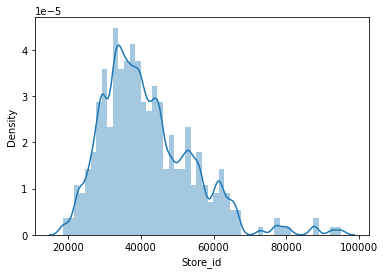

In [21]:
sns.distplot(train['Store_id'])

<AxesSubplot:xlabel='Sales', ylabel='Density'>

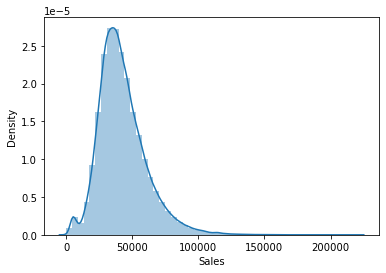

In [22]:
#sns.pairplot(train,corner=True,diag_kind='kde')
sns.distplot(train['Sales'])

<AxesSubplot:ylabel='Density'>

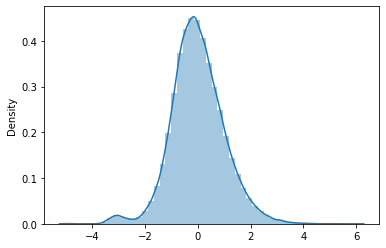

In [23]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')

sales_transform = pt.fit_transform(train['Sales'].values[:,np.newaxis])
sns.distplot(sales_transform)

In [24]:
y_train = pd.Series(np.ravel(sales_transform), index=train.index)
X_train =train.loc[:,train.columns !='Sales']

In [25]:
X_train.head()

,Store_id,Holiday,Discount,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,...,Region_Code_R4,Month,Day,Dayofyear,Weekofyear,Dayofweek,is_month_start,is_month_end,is_quarter_start,is_quarter_end
ID,,,,,,,,,,,,,,,,,,,,,
T1000001,34206.0,1,1,0,0,0,0,1,0,0,...,0,1,1,1,1,0,1,0,1,0
T1000115,45045.0,1,1,0,1,0,0,0,0,0,...,0,1,1,1,1,0,1,0,1,0
T1000128,59613.0,1,1,0,0,1,1,0,0,0,...,0,1,1,1,1,0,1,0,1,0
T1000097,38220.0,1,1,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,0,1,0
T1000133,41928.0,1,1,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,0,1,0


In [26]:
y_train.head()

ID
T1000001   -2.790544
T1000115   -1.563447
T1000128    0.871821
T1000097    0.693251
T1000133   -0.251945
dtype: float64

## Model Building

In [27]:
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression

In [28]:
#Create a linear regression estimator 

linreg = LinearRegression()

#Use RFECV to pick best features, using Stratified Kfold
rfecv =   RFECV(linreg, cv=5, scoring='neg_mean_squared_error',verbose = 1,n_jobs=-1)

In [29]:

selector = rfecv.fit(X_train, y_train)
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [30]:
list(zip(X_train.columns,selector.support_,selector.ranking_))

[('Store_id', True, 1),
 ('Holiday', True, 1),
 ('Discount', True, 1),
 ('Store_Type_S2', True, 1),
 ('Store_Type_S3', True, 1),
 ('Store_Type_S4', True, 1),
 ('Location_Type_L2', True, 1),
 ('Location_Type_L3', True, 1),
 ('Location_Type_L4', True, 1),
 ('Location_Type_L5', True, 1),
 ('Region_Code_R2', True, 1),
 ('Region_Code_R3', True, 1),
 ('Region_Code_R4', True, 1),
 ('Month', True, 1),
 ('Day', True, 1),
 ('Dayofyear', True, 1),
 ('Weekofyear', True, 1),
 ('Dayofweek', True, 1),
 ('is_month_start', True, 1),
 ('is_month_end', True, 1),
 ('is_quarter_start', True, 1),
 ('is_quarter_end', True, 1)]

In [31]:
print("Optimal number of features from RFECV :")
print(selector.n_features_)

Optimal number of features from RFECV :
22


<AxesSubplot:>

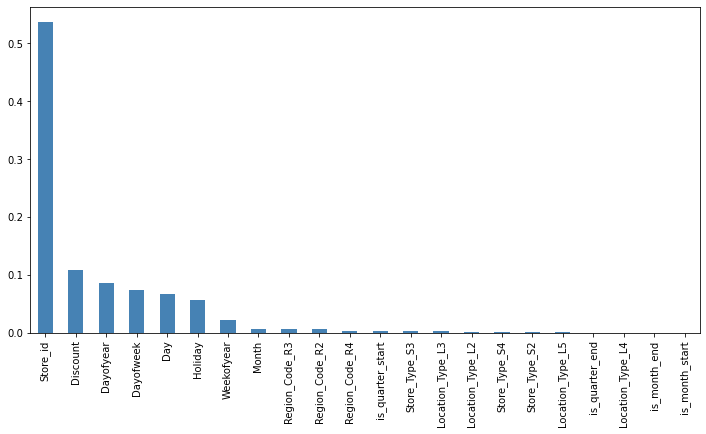

In [32]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)

feat_imp = pd.Series(reg.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feat_imp.plot.bar(color='steelblue', figsize=(12, 6))

<AxesSubplot:>

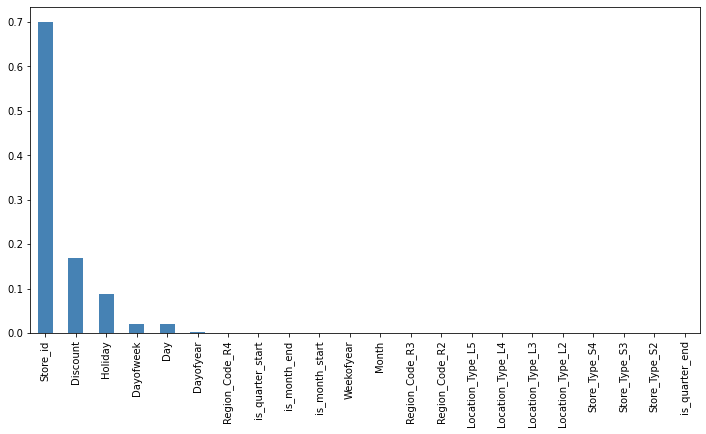

In [33]:
from sklearn.ensemble import RandomForestRegressor
rand_reg = RandomForestRegressor(n_estimators = 100, max_depth=5)
rand_reg.fit(X_train, y_train)

rand_feat_imp = pd.Series(rand_reg.feature_importances_, index=X_train.columns).sort_values(ascending=False)

rand_feat_imp.plot.bar(color='steelblue', figsize=(12, 6))

In [34]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [35]:
X_train_col=X_train.copy()

In [36]:
vif = pd.DataFrame()
X = X_train_col
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif 

,Features,VIF
13,Month,3550.39
15,Dayofyear,3288.85
16,Weekofyear,170.15
0,Store_id,69.56
14,Day,23.12
5,Store_Type_S4,4.34
6,Location_Type_L2,3.31
17,Dayofweek,3.25
10,Region_Code_R2,2.09
3,Store_Type_S2,2.01


In [37]:
X_train_col.drop('Month',axis=1, inplace=True)
vif = pd.DataFrame()
X = X_train_col
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
15,Weekofyear,169.86
14,Dayofyear,167.19
0,Store_id,16.60
13,Day,4.96
5,Store_Type_S4,3.71
16,Dayofweek,3.15
6,Location_Type_L2,2.55
10,Region_Code_R2,2.02
3,Store_Type_S2,1.91
20,is_quarter_end,1.87


In [38]:
X_train_col.drop('Weekofyear',axis=1, inplace=True)
vif = pd.DataFrame()
X = X_train_col
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,Store_id,16.52
13,Day,4.96
14,Dayofyear,3.93
5,Store_Type_S4,3.71
15,Dayofweek,3.15
6,Location_Type_L2,2.55
10,Region_Code_R2,2.02
3,Store_Type_S2,1.91
11,Region_Code_R3,1.83
2,Discount,1.83


In [39]:

X_train_1=sm.add_constant(X_train_col)    # Adding constant
X_train_1.shape

(133225, 21)

In [40]:
lm_1 = sm.OLS(y_train,X_train_1).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                 1.253e+04
Date:                Sat, 18 Sep 2021   Prob (F-statistic):               0.00
Time:                        04:49:12   Log-Likelihood:            -1.1855e+05
No. Observations:              133225   AIC:                         2.371e+05
Df Residuals:                  133204   BIC:                         2.373e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.2933      0.014  

In [41]:
#Removing kw_max_min and building model
X_train_2=X_train_1.drop('Region_Code_R3', axis=1)   

### Model 2

In [42]:
lm_2 = sm.OLS(y_train,X_train_2).fit()
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                 1.319e+04
Date:                Sat, 18 Sep 2021   Prob (F-statistic):               0.00
Time:                        04:49:12   Log-Likelihood:            -1.1855e+05
No. Observations:              133225   AIC:                         2.371e+05
Df Residuals:                  133205   BIC:                         2.373e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.2933      0.013  

In [43]:
#Removing kw_max_min and building model
X_train_3=X_train_2.drop('Region_Code_R2', axis=1)   

### Model 3

In [44]:
lm_3 = sm.OLS(y_train,X_train_3).fit()
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                 1.392e+04
Date:                Sat, 18 Sep 2021   Prob (F-statistic):               0.00
Time:                        04:49:13   Log-Likelihood:            -1.1855e+05
No. Observations:              133225   AIC:                         2.371e+05
Df Residuals:                  133206   BIC:                         2.373e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.2926      0.013  

In [45]:
#Predict values
y_train_pred_scaled = lm_3.predict(X_train_3)

In [46]:
y_train_scaled_arr = y_train.values.ravel()
print(y_train_scaled_arr.shape)

(133225,)


In [47]:
res=y_train_scaled_arr- y_train_pred_scaled

Text(0, 0.5, 'residual')

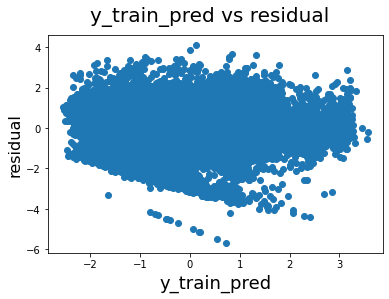

In [48]:
fig = plt.figure()
plt.scatter(y_train_pred_scaled,res)
fig.suptitle('y_train_pred vs residual', fontsize=20)              # Plot heading 
plt.xlabel('y_train_pred', fontsize=18)                          # X-label
plt.ylabel('residual', fontsize=16) 

Text(0.5, 0, 'Errors')

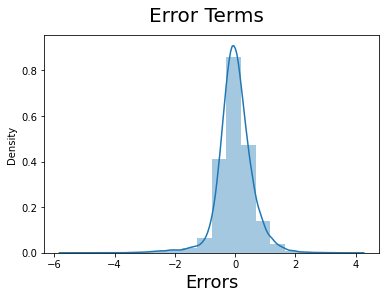

In [49]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((res), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

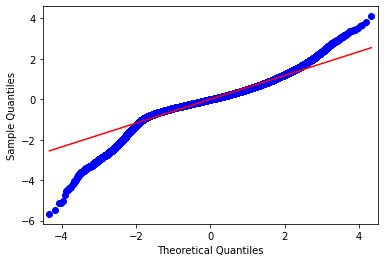

In [50]:
sm.qqplot(res,line='s')
plt.show()

In [51]:
residual_results=pd.DataFrame()
residual_results['Actual'] = y_train
residual_results['predicted'] = y_train_pred_scaled.values
residual_results['residual'] = residual_results['Actual'] - residual_results['predicted']
residual_results['sales']=train['Sales'].values
residual_results['predicted_sales'] = pt.inverse_transform(y_train_pred_scaled[:, np.newaxis])

In [52]:
residual_results.head()

,Actual,predicted,residual,sales,predicted_sales
ID,,,,,
T1000001,-2.790544,-0.339209,-2.451335,7011.84,34898.467097
T1000115,-1.563447,0.311287,-1.874733,18137.52,46193.374472
T1000128,0.871821,1.042761,-0.170940,57288.00,60925.221707
T1000097,0.693251,-0.057412,0.750663,53615.52,39584.771979
T1000133,-0.251945,0.115188,-0.367133,36316.08,42610.864727


In [53]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    msle = metrics.mean_squared_log_error(y_true,y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MSLE: ', round(msle,4))

In [54]:
regression_results(residual_results['sales'].values, residual_results['predicted_sales'].values)

explained_variance:  0.6775
r2:  0.6761
MAE:  7201.979
MSE:  105160212.2402
RMSE:  10254.7653
MSLE:  0.1


In [55]:
from sklearn.model_selection import GridSearchCV


In [56]:
from xgboost import XGBRegressor

xgbr_pipeline = Pipeline([("xgbr_model", XGBRegressor(objective="reg:squarederror", verbosity=1, 
                                                      random_state=42, n_jobs=-1))])

xgbr_pipeline_params = {
                        "xgbr_model__max_depth": [5],
                        "xgbr_model__learning_rate": [0.01,0.1],
                    }

xgbr_grid_pipeline = GridSearchCV(xgbr_pipeline, xgbr_pipeline_params, scoring= 'neg_mean_squared_error', 
                        cv = 5, 
                        return_train_score=True,
                        n_jobs=-1,
                        verbose = 1)
# fit
xgbr_grid_pipeline.fit(X_train,y_train)
print(xgbr_grid_pipeline.best_params_)
xgbr_model = xgbr_grid_pipeline.best_estimator_
print(xgbr_grid_pipeline.best_score_)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'xgbr_model__learning_rate': 0.1, 'xgbr_model__max_depth': 5}
-0.4515731632742141


In [57]:
y_train_pred_xgbr = xgbr_model.predict(X_train)

In [58]:
xgbr_residual = pd.DataFrame()
xgbr_residual['Actual'] = y_train
xgbr_residual['predicted'] = y_train_pred_xgbr
xgbr_residual['residual'] = xgbr_residual['Actual'] - xgbr_residual['predicted']
xgbr_residual['sales'] = train['Sales'].values
xgbr_residual['predicted_sales'] =  pt.inverse_transform(y_train_pred_xgbr[:,np.newaxis]).ravel()
xgbr_residual.head()

,Actual,predicted,residual,sales,predicted_sales
ID,,,,,
T1000001,-2.790544,0.006772,-2.797317,7011.84,40696.222656
T1000115,-1.563447,-0.058297,-1.505150,18137.52,39569.570312
T1000128,0.871821,0.240671,0.631150,57288.00,44885.558594
T1000097,0.693251,0.091296,0.601956,53615.52,42184.894531
T1000133,-0.251945,0.084421,-0.336366,36316.08,42062.746094


In [59]:
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.neighbors import KNeighborsRegressor


# knn_pipeline = Pipeline([("knn", KNeighborsRegressor())])

# knn_pipeline_params = {'knn__n_neighbors': list(range(40,100,4))}

# knn_grid_pipeline = GridSearchCV(knn_pipeline, knn_pipeline_params, scoring= 'neg_mean_squared_error', 
#                         cv = 5, 
#                         return_train_score=True,
#                         n_jobs=-1,
#                         verbose = 1)
# # fit
# knn_grid_pipeline.fit(X_train, y_train)
# print(knn_grid_pipeline.best_params_)
# knn_model = knn_grid_pipeline.best_estimator_
# print(knn_grid_pipeline.best_score_)


In [60]:
# y_train_pred_knn = knn_model.predict(X_train)

In [61]:
# knn_residual = pd.DataFrame()
# knn_residual['Actual'] = y_train
# knn_residual['predicted'] = y_train_pred_knn
# knn_residual['residual'] = knn_residual['Actual'] - knn_residual['predicted']
# knn_residual['sales'] = train['Sales'].values
# knn_residual['predicted_sales'] = pt.inverse_transform(y_train_pred_knn[:,np.newaxis]).ravel()
# knn_residual.head()

In [62]:
from sklearn.feature_selection import SelectFromModel

rf_pipeline = Pipeline([("rfr", RandomForestRegressor(criterion='mse', random_state=100, max_features='sqrt',n_jobs=-1,verbose=1))])

rf_pipeline_params = {"rfr__n_estimators":[100,200],
           "rfr__max_leaf_nodes":[30,60],
            "rfr__bootstrap":[True ,False]}

rf_grid_pipeline = GridSearchCV(rf_pipeline, rf_pipeline_params, scoring= 'neg_mean_squared_error', 
                        cv = 5, 
                        return_train_score=True,
                        n_jobs=-1,
                        verbose = 1)
# fit
rf_grid_pipeline.fit(X_train, y_train)
print(rf_grid_pipeline.best_params_)
rf_model = rf_grid_pipeline.best_estimator_
print(rf_grid_pipeline.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.4s


{'rfr__bootstrap': False, 'rfr__max_leaf_nodes': 60, 'rfr__n_estimators': 200}
-0.40864384554784056


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.0s finished


In [63]:
y_train_pred_rf = rf_model.predict(X_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished


In [64]:
rf_residual = pd.DataFrame()
rf_residual['Actual'] = y_train
rf_residual['predicted'] = y_train_pred_rf
rf_residual['residual'] = rf_residual['Actual'] - rf_residual['predicted']
rf_residual['sales'] = train['Sales'].values
rf_residual['predicted_sales'] = pt.inverse_transform(y_train_pred_rf[:,np.newaxis]).ravel()
rf_residual.head()

,Actual,predicted,residual,sales,predicted_sales
ID,,,,,
T1000001,-2.790544,-0.187206,-2.603338,7011.84,37387.222247
T1000115,-1.563447,0.143525,-1.706972,18137.52,43119.038822
T1000128,0.871821,0.503032,0.368789,57288.00,49845.673565
T1000097,0.693251,0.004738,0.688514,53615.52,40660.731278
T1000133,-0.251945,0.055152,-0.307097,36316.08,41544.822713


In [65]:
# from sklearn.svm import SVR

In [66]:
# svr_pipeline = Pipeline([("svr", SVR(kernel='rbf'))])
# svr_pipeline_params = {"svr__C":[0.01, 0.1]}

# svr_grid_pipeline = GridSearchCV(svr_pipeline, svr_pipeline_params, scoring= 'neg_mean_squared_error', 
#                         cv = 5, 
#                         return_train_score=True,
#                         n_jobs=-1,
#                         verbose = 1)
# # fit
# svr_grid_pipeline.fit(X_train, y_train)
# print(svr_grid_pipeline.best_params_)
# svr_model = svr_grid_pipeline.best_estimator_
# print(svr_grid_pipeline.best_score_)

In [67]:
# y_train_pred_svr = svr_model.predict(X_train)

In [68]:
# svr_residual = pd.DataFrame()
# svr_residual['Actual'] = y_train
# svr_residual['predicted'] = y_train_pred_svr
# svr_residual['residual'] = svr_residual['Actual'] - svr_residual['predicted']
# svr_residual['sales'] = train['Sales'].values
# svr_residual['predicted_sales'] = pt.inverse_transform(y_train_pred_svr[:,np.newaxis]).ravel()
# svr_residual.head()

## Predictions on the test dataset

In [69]:
print(validation.shape)
validation["Store_id"].replace(avg_sales_by_store_id, inplace=True)
validation["Discount"].replace({'Yes':1,'No':0}, inplace=True)


(55115, 9)


In [70]:
validation = encode_and_bind(validation,"Store_Type")
validation = encode_and_bind(validation,"Location_Type")
validation = encode_and_bind(validation,"Region_Code")

In [71]:

validation.drop(["Store_Type","Location_Type", "Region_Code"],axis=1,inplace=True)

validation.head()

,Store_id,Date,Holiday,Discount,#Order,Sales,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R2,Region_Code_R3,Region_Code_R4
ID,,,,,,,,,,,,,,,,
T1133439,34206.0,2019-01-01,1,1,54,36021.96,0,0,0,0,1,0,0,0,0,0
T1133282,45045.0,2019-01-01,1,0,62,40927.41,0,1,0,0,0,0,0,0,1,0
T1133464,59613.0,2019-01-01,1,1,84,50425.62,0,0,1,1,0,0,0,0,0,0
T1133497,38220.0,2019-01-01,1,0,47,31112.88,0,0,0,0,0,0,0,1,0,0
T1133493,41928.0,2019-01-01,1,1,55,41358.24,0,0,0,0,0,0,0,0,1,0


In [72]:
validation['Month'] = validation['Date'].dt.month
validation['Day'] = validation['Date'].dt.day
validation['Dayofyear'] = validation['Date'].dt.dayofyear
validation['Weekofyear'] = validation['Date'].dt.weekofyear
validation['Dayofweek'] = validation['Date'].dt.dayofweek
validation['is_month_start'] = validation['Date'].dt.is_month_start.astype(int)
validation['is_month_end'] = validation['Date'].dt.is_month_end.astype(int)
validation['is_quarter_start'] = validation['Date'].dt.is_quarter_start.astype(int)
validation['is_quarter_end'] = validation['Date'].dt.is_quarter_end.astype(int)

validation.drop(['Date', '#Order'], axis=1, inplace=True)


In [73]:
sales_transform_val = pt.transform(validation['Sales'].values[:,np.newaxis])

In [74]:
y_validation = pd.Series(np.ravel(sales_transform_val), index=validation.index)
X_validation =validation.loc[:,validation.columns !='Sales']

In [75]:
X_validation.head()

,Store_id,Holiday,Discount,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,...,Region_Code_R4,Month,Day,Dayofyear,Weekofyear,Dayofweek,is_month_start,is_month_end,is_quarter_start,is_quarter_end
ID,,,,,,,,,,,,,,,,,,,,,
T1133439,34206.0,1,1,0,0,0,0,1,0,0,...,0,1,1,1,1,1,1,0,1,0
T1133282,45045.0,1,0,0,1,0,0,0,0,0,...,0,1,1,1,1,1,1,0,1,0
T1133464,59613.0,1,1,0,0,1,1,0,0,0,...,0,1,1,1,1,1,1,0,1,0
T1133497,38220.0,1,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,0,1,0
T1133493,41928.0,1,1,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,0,1,0


### Linear Regression Model

In [76]:

def plot_errors(model,X_input, y_actual, title):
    y_train_pred = model.predict(X_input)
    try:
        residu=y_actual.values.ravel()- y_train_pred.ravel() ##can use reshape(-1,1) instead of ravel to covert to (n,)
    except:
        residu=y_actual.values.ravel()- y_train_pred.values

    fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3,figsize=(16,4))

    ax1.scatter(y_train_pred,residu)
    ax1.set_xlabel('y_pred')                          # X-label
    ax1.set_ylabel('residual') 
    ax1.set_title('y_pred vs residual')

    sns.distplot((residu), bins = 20,ax=ax2)
    ax2.set_xlabel('Errors')                         # X-label
    ax2.set_title('Density plot of residuals')

    sm.qqplot(residu,line='s',ax=ax3)
    ax3.set_title('QQ Plot')
    plt.suptitle(title)
    plt.show()



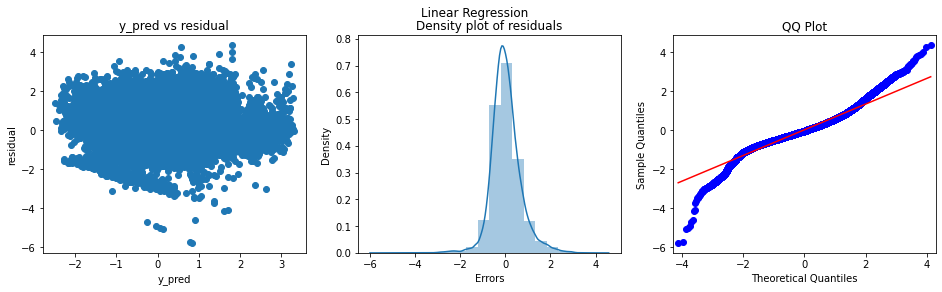

In [77]:
plot_errors(lm_3, sm.add_constant(X_validation)[X_train_3.columns], y_validation, 'Linear Regression')

In [79]:

def residual_errors(model,X_input, y_actual):
    y_train_pred = model.predict(X_input)
    residual_results=pd.DataFrame()
    residual_results['Actual'] =y_actual.values.ravel()
    residual_results['predicted'] = y_train_pred.ravel()
    residual_results['residual'] = residual_results['Actual'] - residual_results['predicted']
    residual_results['sales']= validation['Sales'].copy()
    residual_results['predicted_sales'] = pt.inverse_transform(y_train_pred[:, np.newaxis])
    residual_results.index = X_input.index
    return residual_results

In [80]:
test_residual_results_lr = residual_errors(lm_3, sm.add_constant(X_validation)[X_train_3.columns], y_validation)

In [82]:
test_residual_results_lr['sales'] = validation['Sales'].copy()
test_residual_results_lr.head()

,Actual,predicted,residual,sales,predicted_sales
ID,,,,,
T1133439,-0.269899,-0.278645,0.008746,36021.96,35879.147021
T1133282,0.020006,-0.298783,0.318789,40927.41,35551.452415
T1133464,0.532782,1.103325,-0.570543,50425.62,62242.528337
T1133497,-0.581943,-0.667482,0.085539,31112.88,29833.883027
T1133493,0.044560,0.175752,-0.131192,41358.24,43700.871393


In [85]:
def regression_metrics(df, model):

    print("\n")
    print("Regression results for actual shares   : ", model, "\n")
    regression_results(df['sales'].values, df['predicted_sales'].values)

In [86]:
regression_metrics(test_residual_results_lr, 'Linear Regression')



Regression results for actual shares   :  Linear Regression 

explained_variance:  0.5902
r2:  0.5856
MAE:  8561.3573
MSE:  157043519.8366
RMSE:  12531.7006
MSLE:  0.1047


### XGBR on whole dataset

In [87]:
y_test_pred_xgbr = xgbr_model.predict(X_validation)

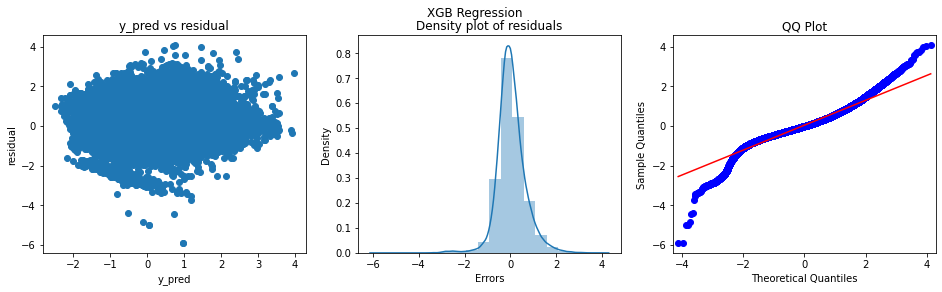

In [88]:
plot_errors(xgbr_model, X_validation, y_validation, 'XGB Regression')

In [89]:
test_residual_results_xgbr = residual_errors(xgbr_model,X_validation, y_validation)

test_residual_results_xgbr['sales'] = validation['Sales'].copy()
test_residual_results_xgbr.head()

,Actual,predicted,residual,sales,predicted_sales
ID,,,,,
T1133439,-0.269899,-0.414336,0.144437,36021.96,33702.070312
T1133282,0.020006,-0.833538,0.853544,40927.41,27432.425781
T1133464,0.532782,-0.109126,0.641908,50425.62,38701.191406
T1133497,-0.581943,-0.977071,0.395128,31112.88,25442.964844
T1133493,0.044560,-0.316245,0.360806,41358.24,35268.597656


In [90]:
regression_metrics(test_residual_results_xgbr, 'XGB Regression')



Regression results for actual shares   :  XGB Regression 

explained_variance:  0.6311
r2:  0.625
MAE:  8093.3349
MSE:  142125157.6473
RMSE:  11921.6256
MSLE:  0.0984


### Random Forest Regressor

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


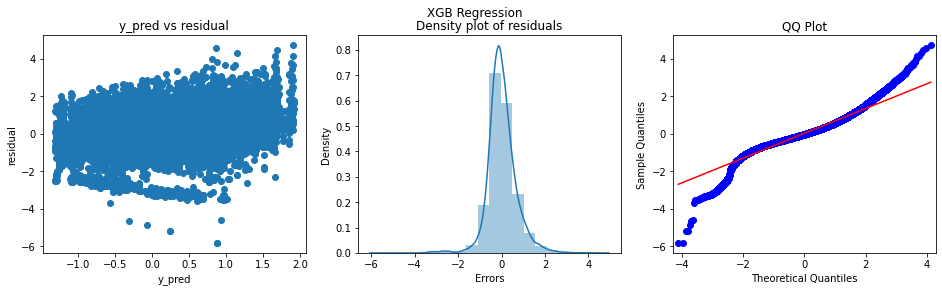

In [91]:
plot_errors(rf_model, X_validation, y_validation, 'XGB Regression')

In [92]:
test_residual_results_rf = residual_errors(rf_model,X_validation, y_validation)

test_residual_results_rf['sales'] = validation['Sales'].copy()
test_residual_results_rf.head()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


,Actual,predicted,residual,sales,predicted_sales
ID,,,,,
T1133439,-0.269899,-0.228314,-0.041586,36021.96,36705.157965
T1133282,0.020006,-0.100804,0.120810,40927.41,38842.663668
T1133464,0.532782,0.499145,0.033636,50425.62,49770.174364
T1133497,-0.581943,-0.288214,-0.293729,31112.88,35723.231341
T1133493,0.044560,0.025504,0.019056,41358.24,41023.671107


In [93]:
regression_metrics(test_residual_results_rf, 'RF Regression')



Regression results for actual shares   :  RF Regression 

explained_variance:  0.5764
r2:  0.5694
MAE:  8507.6807
MSE:  163172750.9471
RMSE:  12773.909
MSLE:  0.1056


### Stacking

In [98]:
stacking = pd.DataFrame()
stacking['lr']     = test_residual_results_lr['predicted'].values

stacking['xgbr']   = test_residual_results_xgbr['predicted'].values
stacking['rf']     = test_residual_results_rf['predicted'].values

stacking['actual'] = test_residual_results_rf['Actual'].values

In [99]:
stacking.head()

,lr,xgbr,rf,actual
0,-0.278645,-0.414336,-0.228314,-0.269899
1,-0.298783,-0.833538,-0.100804,0.020006
2,1.103325,-0.109126,0.499145,0.532782
3,-0.667482,-0.977071,-0.288214,-0.581943
4,0.175752,-0.316245,0.025504,0.044560


In [100]:
from sklearn.linear_model import ElasticNet

In [101]:
stack_pipeline = Pipeline([("elasticnet", ElasticNet(random_state=0))])

stack_pipeline_params = {'elasticnet__l1_ratio':[0,0.2,0.5,0.8,1],
                            'elasticnet__alpha':[0.001,0.01,0.1,],
                           'elasticnet__fit_intercept':[True,False]}

stack_grid_pipeline = GridSearchCV(stack_pipeline, stack_pipeline_params, scoring= 'neg_mean_squared_error', 
                        cv = 5, 
                        return_train_score=True,
                        n_jobs=-1,
                        verbose = 1)
# fit
stack_grid_pipeline.fit(stacking[['lr','xgbr','rf']],stacking['actual'])
print(stack_grid_pipeline.best_params_)
stack_model = stack_grid_pipeline.best_estimator_
print(stack_grid_pipeline.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'elasticnet__alpha': 0.01, 'elasticnet__fit_intercept': False, 'elasticnet__l1_ratio': 0}
-0.39305924425498906


# Final Submission

In [102]:
print(unseen.shape)
unseen["Store_id"].replace(avg_sales_by_store_id, inplace=True)
unseen["Discount"].replace({'Yes':1,'No':0}, inplace=True)


(22265, 7)


In [103]:

unseen = encode_and_bind(unseen,"Store_Type")
unseen = encode_and_bind(unseen,"Location_Type")
unseen = encode_and_bind(unseen,"Region_Code")

In [104]:
unseen.drop(["Store_Type","Location_Type", "Region_Code"],axis=1,inplace=True)

unseen.head()

,Store_id,Date,Holiday,Discount,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R2,Region_Code_R3,Region_Code_R4
ID,,,,,,,,,,,,,,
T1188341,54291.0,2019-06-01,0,0,0,0,1,1,0,0,0,0,1,0
T1188342,38886.0,2019-06-01,0,0,0,0,0,0,0,0,0,0,0,0
T1188343,72951.0,2019-06-01,0,0,0,0,1,1,0,0,0,0,0,0
T1188344,36102.0,2019-06-01,0,0,0,0,0,0,0,0,0,0,0,1
T1188345,41193.0,2019-06-01,0,0,0,0,0,0,0,0,0,1,0,0


In [105]:
unseen['Month'] = unseen['Date'].dt.month
unseen['Day'] = unseen['Date'].dt.day
unseen['Dayofyear'] = unseen['Date'].dt.dayofyear
unseen['Weekofyear'] = unseen['Date'].dt.weekofyear
unseen['Dayofweek'] = unseen['Date'].dt.dayofweek
unseen['is_month_start'] = unseen['Date'].dt.is_month_start.astype(int)
unseen['is_month_end'] = unseen['Date'].dt.is_month_end.astype(int)
unseen['is_quarter_start'] = unseen['Date'].dt.is_quarter_start.astype(int)
unseen['is_quarter_end'] = unseen['Date'].dt.is_quarter_end.astype(int)

unseen.drop(['Date'], axis=1, inplace=True)


In [106]:
X_unseen =unseen.loc[:,unseen.columns !='Sales']

In [107]:
X_unseen.head()

,Store_id,Holiday,Discount,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,...,Region_Code_R4,Month,Day,Dayofyear,Weekofyear,Dayofweek,is_month_start,is_month_end,is_quarter_start,is_quarter_end
ID,,,,,,,,,,,,,,,,,,,,,
T1188341,54291.0,0,0,0,0,1,1,0,0,0,...,0,6,1,152,22,5,1,0,0,0
T1188342,38886.0,0,0,0,0,0,0,0,0,0,...,0,6,1,152,22,5,1,0,0,0
T1188343,72951.0,0,0,0,0,1,1,0,0,0,...,0,6,1,152,22,5,1,0,0,0
T1188344,36102.0,0,0,0,0,0,0,0,0,0,...,1,6,1,152,22,5,1,0,0,0
T1188345,41193.0,0,0,0,0,0,0,0,0,0,...,0,6,1,152,22,5,1,0,0,0


### Linear Regression submission

In [108]:
linear_results =pd.DataFrame()
linear_results['lr']=  lm_3.predict(sm.add_constant(X_unseen)[X_train_3.columns])

In [111]:
submission_1_lr = pd.DataFrame()
submission_1_lr['ID'] = X_unseen.index
submission_1_lr['Sales'] = pt.inverse_transform(linear_results.lr.values[:, np.newaxis])

In [112]:
submission_1_lr.head()

,ID,Sales
0,T1188341,49481.148095
1,T1188342,34930.675570
2,T1188343,67827.934655
3,T1188344,32683.151847
4,T1188345,36680.305034


In [113]:
submission_1_lr.to_csv("submission_1_lr.csv", index=False)

### XGBR submission

In [114]:
y_unseen_pred_xgbr = xgbr_model.predict(X_unseen)

In [116]:
submission_2_xgbr = pd.DataFrame()
submission_2_xgbr['ID'] = X_unseen.index
submission_2_xgbr['Sales'] = pt.inverse_transform(y_unseen_pred_xgbr[:, np.newaxis])

In [117]:
submission_2_xgbr.head()

,ID,Sales
0,T1188341,55689.757812
1,T1188342,40475.023438
2,T1188343,76435.656250
3,T1188344,38636.394531
4,T1188345,43491.062500


In [118]:
submission_2_xgbr.to_csv("submission_2_xgbr.csv", index=False)

### RF submission

In [119]:
y_unseen_pred_rf = rf_model.predict(X_unseen)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [120]:
submission_3_rf = pd.DataFrame()
submission_3_rf['ID'] = X_unseen.index
submission_3_rf['Sales'] = pt.inverse_transform(y_unseen_pred_rf[:, np.newaxis])

In [122]:
submission_3_rf.head()

,ID,Sales
0,T1188341,58221.765039
1,T1188342,40543.383951
2,T1188343,71315.046844
3,T1188344,38686.524052
4,T1188345,40976.325244


In [123]:
submission_3_rf.to_csv("submission_3_rf.csv", index=False)

## Stacking on unseen dataset

In [124]:
unseen_stacking = pd.DataFrame()

unseen_stacking['lr']     = linear_results['lr'].values
unseen_stacking['xgbr']   = xgbr_model.predict(X_unseen)
unseen_stacking['rf']     = rf_model.predict(X_unseen)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [125]:
unseen_stacking.head()

,lr,xgbr,rf
0,0.484238,0.794881,0.916245
1,-0.337206,-0.005926,-0.001998
2,1.352825,1.716781,1.503075
3,-0.479446,-0.112943,-0.109990
4,-0.229819,0.164157,0.022801


In [127]:
stacking_submission = pd.DataFrame()
stacking_submission['ID']= X_unseen.index
stacking_submission['Sales'] = pt.inverse_transform(stack_model.predict(unseen_stacking)[:, np.newaxis]) 

In [128]:
stacking_submission.head()

,ID,Sales
0,T1188341,57087.998557
1,T1188342,39489.348443
2,T1188343,77273.513156
3,T1188344,37387.714580
4,T1188345,41680.883633


In [129]:
stacking_submission.to_csv("submission_4_stacking.csv", index= False)